In [ ]:
!pip install   scikit-optimize optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 10.8 MB/s eta 0:00:00


In [ ]:
Optuna

NameError: name 'Optuna' is not defined

ChatGPT

X shape: (206, 9) y shape: (206,)

===== Tuning SVM (SVR) =====


  0%|          | 0/40 [00:00<?, ?it/s]

Completed SVM trials: 40


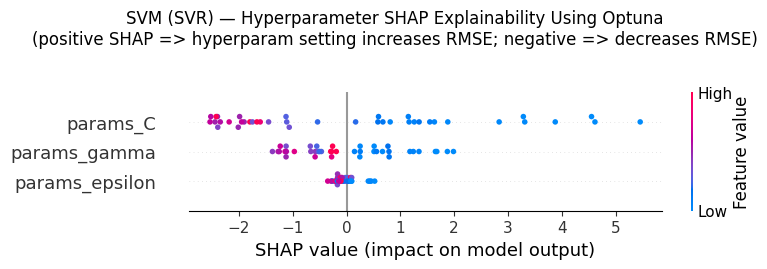

Completed SHAP explainability for hyperparameters of SVM (SVR).


===== Tuning Decision Tree =====


  0%|          | 0/40 [00:00<?, ?it/s]

Completed Decision Tree trials: 40


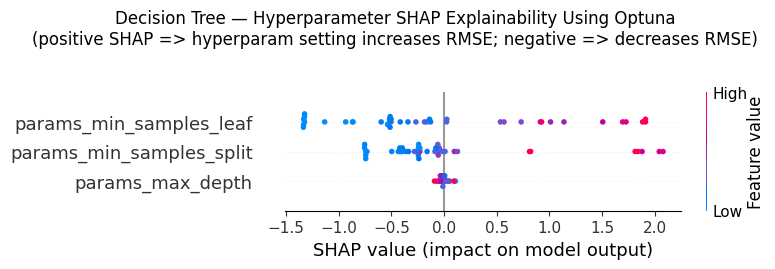

Completed SHAP explainability for hyperparameters of Decision Tree.


===== Tuning Random Forest =====


  0%|          | 0/40 [00:00<?, ?it/s]

Completed Random Forest trials: 40


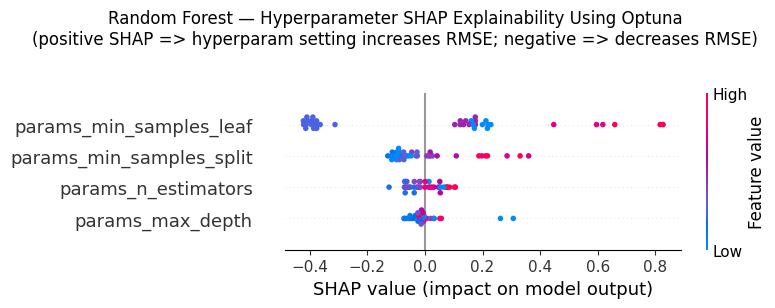

Completed SHAP explainability for hyperparameters of Random Forest.


===== Tuning Extra Trees =====


  0%|          | 0/40 [00:00<?, ?it/s]

Completed Extra Trees trials: 40


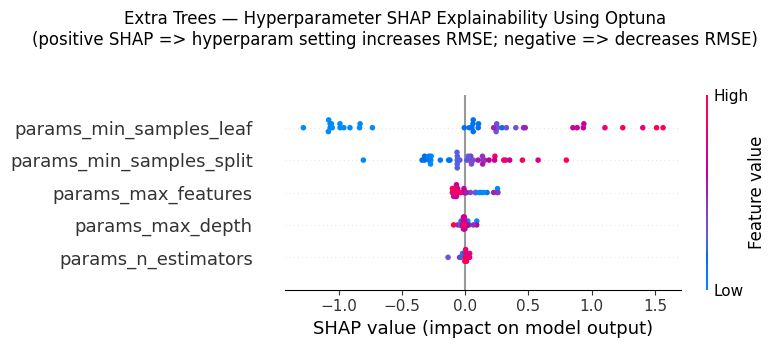

Completed SHAP explainability for hyperparameters of Extra Trees.


===== Tuning XGBoost =====


  0%|          | 0/40 [00:00<?, ?it/s]

Completed XGBoost trials: 40


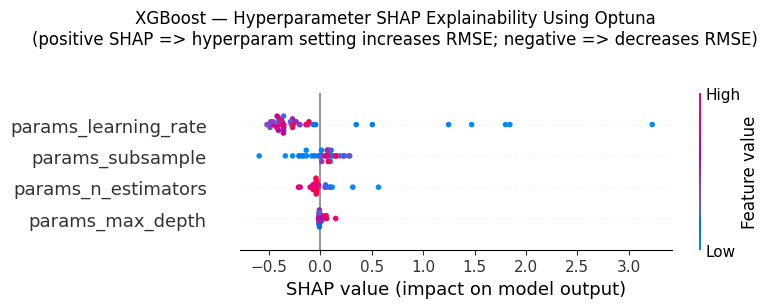

Completed SHAP explainability for hyperparameters of XGBoost.


===== Tuning MLP =====


  0%|          | 0/40 [00:00<?, ?it/s]

Completed MLP trials: 40


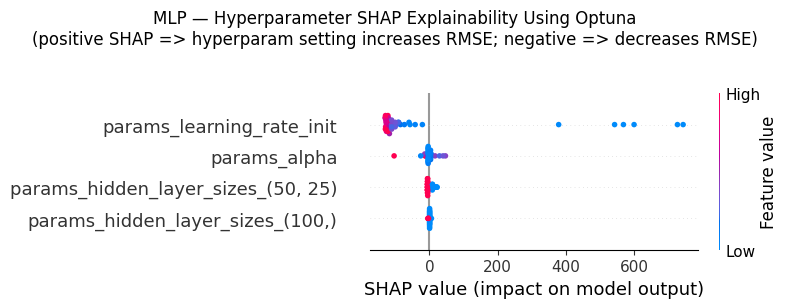

Completed SHAP explainability for hyperparameters of MLP.



In [ ]:
# hyperparam_shap_optuna_all_regressors.py
# Run in notebook / Colab. Requires: optuna, shap, xgboost, scikit-learn, pandas, matplotlib, numpy

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import optuna
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.pipeline import make_pipeline

# -----------------------------
# USER SETTINGS
# -----------------------------
DATA_PATH = '/content/Density_Prediction_Dataset.csv'   # <-- change as needed
TARGET_COL = 'Density (ρ)'                             # keep exactly as in your CSV
N_TRIALS = 40                                          # change if you want more/less tuning
RANDOM_SEED = 42

# -----------------------------
# 1) Preprocessing function (based on yours)
# -----------------------------
def load_and_preprocess_data(file_path):
    """Load and preprocess the dataset (outlier removal, label encoding, scaling)."""
    df = pd.read_csv(file_path)

    # Remove outliers using IQR method (applied on numeric cols)
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    for col in numerical_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    # Label encoding for categorical variables
    le = LabelEncoder()
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        df[col] = le.fit_transform(df[col])

    # Separate features and target
    X = df.drop(TARGET_COL, axis=1)
    y = df[TARGET_COL]

    # Feature scaling (StandardScaler) - return DataFrame for column names
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    return X_scaled, y

# -----------------------------
# 2) Load data
# -----------------------------
X, y = load_and_preprocess_data(DATA_PATH)
print("X shape:", X.shape, "y shape:", y.shape)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

# -----------------------------
# 3) Helper: common utilities for each regressor study
# -----------------------------
def run_optuna_study(name, objective_fn, n_trials=N_TRIALS, direction="minimize", seed=RANDOM_SEED):
    """Run an Optuna study and return the study object."""
    sampler = optuna.samplers.TPESampler(seed=seed)
    study = optuna.create_study(direction=direction, sampler=sampler, study_name=name)
    study.optimize(objective_fn, n_trials=n_trials, show_progress_bar=True)
    return study

def extract_trials_df(study):
    """Return a cleaned dataframe of trials (params + value)."""
    df_trials = study.trials_dataframe(attrs=("number", "value", "params", "state"))
    # Drop pruned/failed if needed; keep only complete trials
    df_trials = df_trials[df_trials["state"] == "COMPLETE"].reset_index(drop=True)
    # Drop state col for convenience
    df_trials = df_trials.drop(columns=["state"])
    return df_trials

def train_meta_model_and_explain(df_trials, reg_name, top_n_show=40):
    """
    Given df_trials (params + value), train a meta-model mapping hyperparams -> performance (value)
    and compute SHAP values to explain which hyperparameters affected performance most.
    """
    if df_trials.shape[0] < 3:
        print(f"Not enough completed trials for {reg_name} to build a meta-model.")
        return

    # Prepare X_hyper and y_perf
    df = df_trials.copy()
    y_perf = df["value"].values  # Optuna objective (we used RMSE so lower is better)

    # Drop Optuna-specific columns if present
    drop_cols = [c for c in ["number", "value"] if c in df.columns]
    X_hyper = df.drop(columns=drop_cols)

    # Convert any object/categorical columns to numeric (one-hot)
    X_hyper = pd.get_dummies(X_hyper, drop_first=True)
    X_hyper = X_hyper.apply(pd.to_numeric, errors="coerce").fillna(0.0)

    # Train meta-model (XGBoost)
    meta_model = xgb.XGBRegressor(n_estimators=200, random_state=RANDOM_SEED, tree_method="hist")
    meta_model.fit(X_hyper, y_perf)

    # SHAP explanation (TreeExplainer for XGBoost)
    explainer = shap.TreeExplainer(meta_model)
    shap_values = explainer.shap_values(X_hyper)

    # Plot SHAP summary
    plt.figure(figsize=(8, 6))
    # Put a caption above the plot (we'll use suptitle)
    plt.suptitle(f"{reg_name} — Hyperparameter SHAP Explainability Using Optuna\n(positive SHAP => hyperparam setting increases RMSE; negative => decreases RMSE)" )
    shap.summary_plot(shap_values, X_hyper, show=False)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave room for suptitle
    plt.show()

    print(f"Completed SHAP explainability for hyperparameters of {reg_name}.\n")

# -----------------------------
# 4) Define Optuna objective functions for each regressor
# -----------------------------
# We'll use RMSE on a validation split as the objective (minimize RMSE)
def make_train_val_split(random_state=RANDOM_SEED):
    return train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=random_state)

# SVM (SVR)
def objective_svm(trial):
    X_tr, X_val, y_tr, y_val = make_train_val_split()
    C = trial.suggest_float("C", 0.1, 100.0, log=True)
    gamma = trial.suggest_float("gamma", 0.001, 1.0, log=True)
    epsilon = trial.suggest_float("epsilon", 0.01, 1.0, log=True)
    model = SVR(C=C, gamma=gamma, epsilon=epsilon)
    model.fit(X_tr, y_tr)
    preds = model.predict(X_val)
    return root_mean_squared_error(y_true=y_val, y_pred=preds)  # RMSE

# Decision Tree
def objective_dt(trial):
    X_tr, X_val, y_tr, y_val = make_train_val_split()
    max_depth = trial.suggest_int("max_depth", 5, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_int("min_samples_leaf", 0.1, 1.0)
    model = DecisionTreeRegressor(max_depth=max_depth,
                                  min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf,
                                  random_state=RANDOM_SEED)
    model.fit(X_tr, y_tr)
    preds = model.predict(X_val)
    return root_mean_squared_error(y_true=y_val, y_pred=preds)

# Random Forest
def objective_rf(trial):
    X_tr, X_val, y_tr, y_val = make_train_val_split()
    n_estimators = trial.suggest_int("n_estimators", 50, 200, step=25)
    max_depth = trial.suggest_int("max_depth", 5, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf,
                                  n_jobs=-1,
                                  random_state=RANDOM_SEED)
    model.fit(X_tr, y_tr)
    preds = model.predict(X_val)
    return root_mean_squared_error(y_true=y_val, y_pred=preds)

# Extra Trees
def objective_et(trial):
    X_tr, X_val, y_tr, y_val = make_train_val_split()
    n_estimators = trial.suggest_int("n_estimators", 50, 300, step=25)
    max_depth = trial.suggest_int("max_depth", 5, 25)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 15)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 8)
    max_features = trial.suggest_float("max_features", 0.1, 1.0)
    model = ExtraTreesRegressor(n_estimators=n_estimators,
                                max_depth=max_depth,
                                min_samples_split=min_samples_split,
                                min_samples_leaf=min_samples_leaf,
                                max_features=max_features,
                                n_jobs=-1,
                                random_state=RANDOM_SEED)
    model.fit(X_tr, y_tr)
    preds = model.predict(X_val)
    return root_mean_squared_error(y_true=y_val, y_pred=preds)

# XGBoost
def objective_xgb(trial):
    X_tr, X_val, y_tr, y_val = make_train_val_split()
    n_estimators = trial.suggest_int("n_estimators", 50, 200, step=25)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    model = xgb.XGBRegressor(n_estimators=n_estimators,
                             max_depth=max_depth,
                             learning_rate=learning_rate,
                             subsample=subsample,
                             objective="reg:squarederror",
                             tree_method="hist",
                             random_state=RANDOM_SEED,
                             n_jobs=-1)
    model.fit(X_tr, y_tr)
    preds = model.predict(X_val)
    return root_mean_squared_error(y_true=y_val, y_pred=preds)

# MLP
def objective_mlp(trial):
    X_tr, X_val, y_tr, y_val = make_train_val_split()
    hidden_choice = trial.suggest_categorical("hidden_layer_sizes", [(50,), (100,), (50,25)])
    alpha = trial.suggest_float("alpha", 0.0001, 0.01, log=True)
    learning_rate_init = trial.suggest_float("learning_rate_init", 0.001, 0.1, log=True)
    model = MLPRegressor(hidden_layer_sizes=hidden_choice,
                         alpha=alpha,
                         learning_rate_init=learning_rate_init,
                         max_iter=500,
                         random_state=RANDOM_SEED)
    model.fit(X_tr, y_tr)
    preds = model.predict(X_val)
    return root_mean_squared_error(y_true=y_val, y_pred=preds)

# -----------------------------
# 5) Run studies (one per regressor) and explain
# -----------------------------
studies = {}

# SVM
print("\n===== Tuning SVM (SVR) =====")
study_svm = run_optuna_study("SVM_SVR", objective_svm, n_trials=N_TRIALS)
studies['SVM'] = study_svm
df_svm = extract_trials_df(study_svm)
print("Completed SVM trials:", df_svm.shape[0])
train_meta_model_and_explain(df_svm, "SVM (SVR)")

# Decision Tree
print("\n===== Tuning Decision Tree =====")
study_dt = run_optuna_study("DecisionTree", objective_dt, n_trials=N_TRIALS)
studies['Decision Tree'] = study_dt
df_dt = extract_trials_df(study_dt)
print("Completed Decision Tree trials:", df_dt.shape[0])
train_meta_model_and_explain(df_dt, "Decision Tree")

# Random Forest
print("\n===== Tuning Random Forest =====")
study_rf = run_optuna_study("RandomForest", objective_rf, n_trials=N_TRIALS)
studies['Random Forest'] = study_rf
df_rf = extract_trials_df(study_rf)
print("Completed Random Forest trials:", df_rf.shape[0])
train_meta_model_and_explain(df_rf, "Random Forest")

# Extra Trees
print("\n===== Tuning Extra Trees =====")
study_et = run_optuna_study("ExtraTrees", objective_et, n_trials=N_TRIALS)
studies['Extra Trees'] = study_et
df_et = extract_trials_df(study_et)
print("Completed Extra Trees trials:", df_et.shape[0])
train_meta_model_and_explain(df_et, "Extra Trees")

# XGBoost
print("\n===== Tuning XGBoost =====")
study_xgb = run_optuna_study("XGBoost", objective_xgb, n_trials=N_TRIALS)
studies['XGBoost'] = study_xgb
df_xgb = extract_trials_df(study_xgb)
print("Completed XGBoost trials:", df_xgb.shape[0])
train_meta_model_and_explain(df_xgb, "XGBoost")

# MLP
print("\n===== Tuning MLP =====")
study_mlp = run_optuna_study("MLP", objective_mlp, n_trials=N_TRIALS)
studies['MLP'] = study_mlp
df_mlp = extract_trials_df(study_mlp)
print("Completed MLP trials:", df_mlp.shape[0])
train_meta_model_and_explain(df_mlp, "MLP")



Copilot

Skopt-ChatGPT-Final

Training set shape: (164, 9)
Test set shape: (42, 9)

Optimizing SVM Hyperparameters
Best RMSE: 1.4919
Best parameters: {'C': 100.0, 'gamma': 0.3398779443983202, 'epsilon': 0.01}

Optimizing Random Forest Hyperparameters
Best RMSE: 4.0861
Best parameters: {'n_estimators': np.int64(57), 'max_depth': np.int64(12), 'min_samples_split': np.int64(2), 'min_samples_leaf': np.int64(1)}

Optimizing Decision Tree Hyperparameters
Best RMSE: 5.0565
Best parameters: {'max_depth': np.int64(20), 'min_samples_split': np.int64(2), 'min_samples_leaf': np.int64(1), 'max_features': 0.8931965640082912}

Optimizing Extra Trees Hyperparameters
Best RMSE: 3.2251
Best parameters: {'n_estimators': np.int64(300), 'max_depth': np.int64(25), 'min_samples_split': np.int64(2), 'min_samples_leaf': np.int64(1), 'max_features': 0.19997512914145152}

Optimizing MLP Hyperparameters
Best RMSE: 5.1715
Best parameters: {'hidden_layer_choice': np.int64(3), 'alpha': 0.00011240827872034722, 'learning_rate_init': 0.093460626053

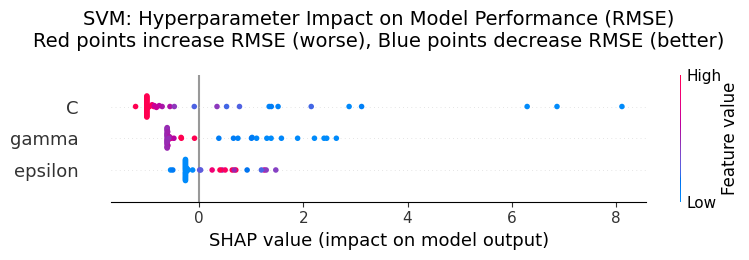


Generating SHAP Bar Plot for SVM
This plot shows the average absolute impact of each hyperparameter


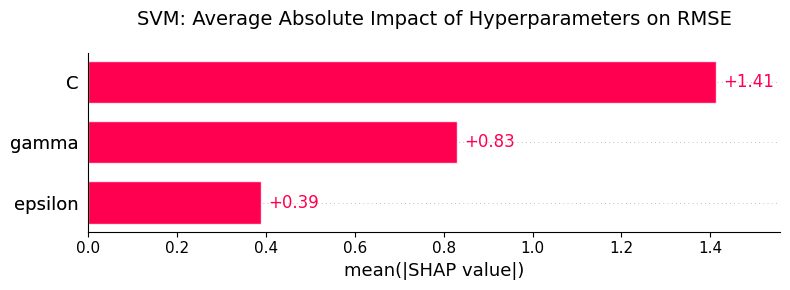


Generating SHAP Summary Plot for Random Forest
This plot shows how each hyperparameter affects the RMSE (lower is better)


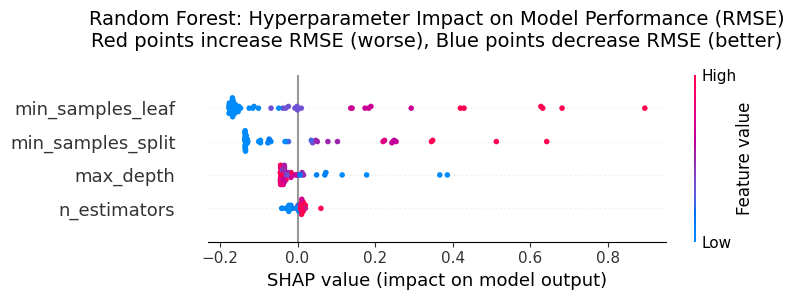


Generating SHAP Bar Plot for Random Forest
This plot shows the average absolute impact of each hyperparameter


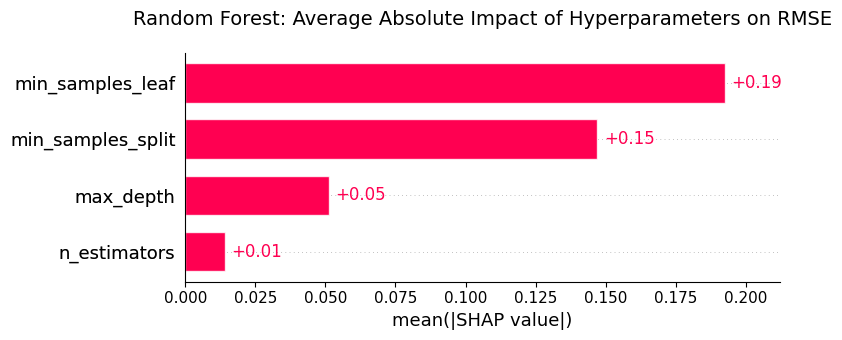


Generating SHAP Summary Plot for Decision Tree
This plot shows how each hyperparameter affects the RMSE (lower is better)


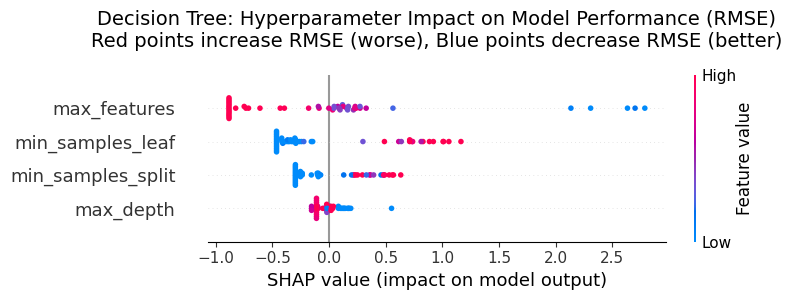


Generating SHAP Bar Plot for Decision Tree
This plot shows the average absolute impact of each hyperparameter


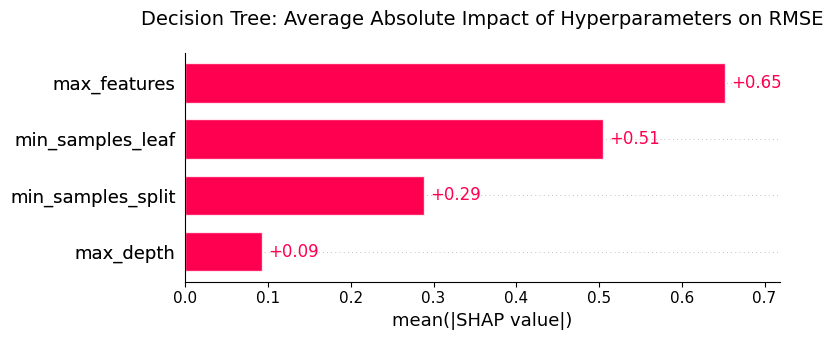


Generating SHAP Summary Plot for Extra Trees
This plot shows how each hyperparameter affects the RMSE (lower is better)


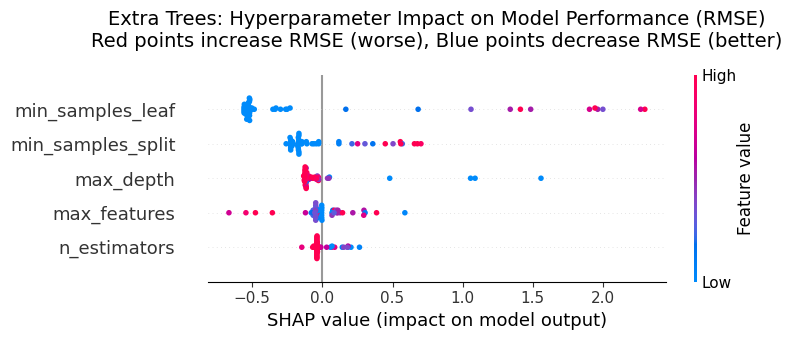


Generating SHAP Bar Plot for Extra Trees
This plot shows the average absolute impact of each hyperparameter


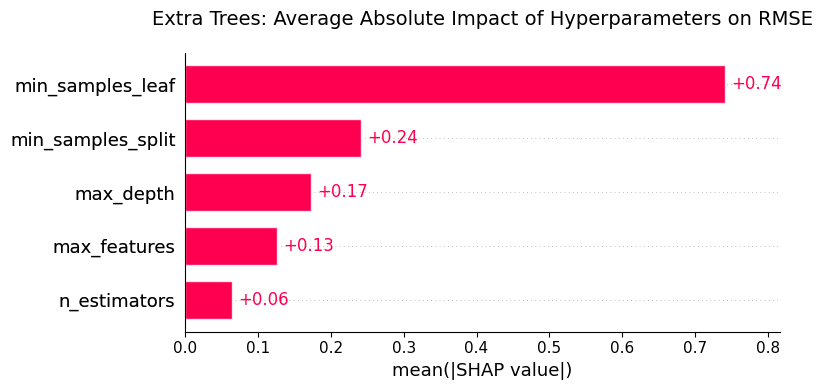


Generating SHAP Summary Plot for MLP
This plot shows how each hyperparameter affects the RMSE (lower is better)


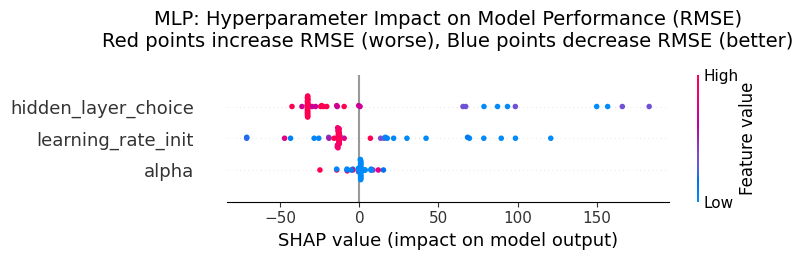


Generating SHAP Bar Plot for MLP
This plot shows the average absolute impact of each hyperparameter


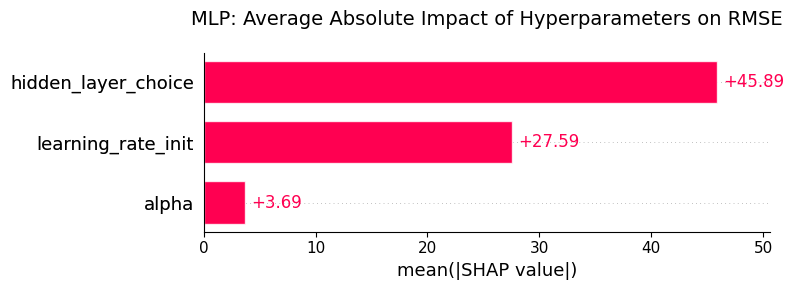


Generating SHAP Summary Plot for XGBoost
This plot shows how each hyperparameter affects the RMSE (lower is better)


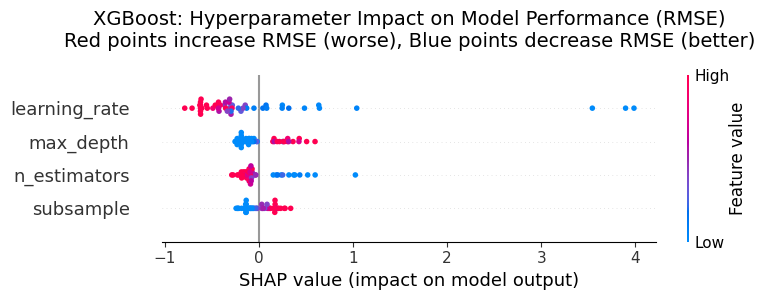


Generating SHAP Bar Plot for XGBoost
This plot shows the average absolute impact of each hyperparameter


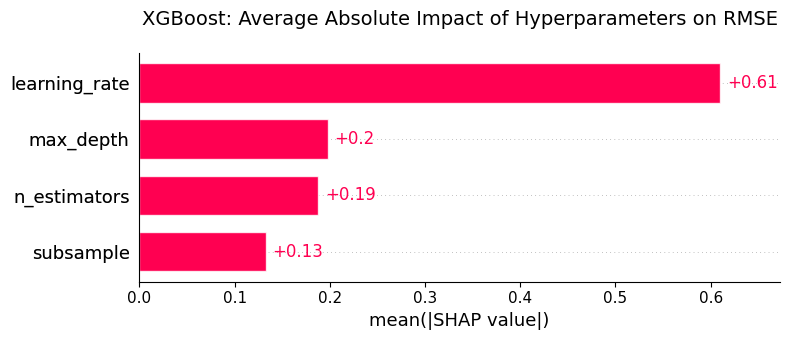


COMPARATIVE HYPERPARAMETER IMPORTANCE ANALYSIS

Best RMSE achieved by each model:
SVM            : 1.4919
Random Forest  : 4.0861
Decision Tree  : 5.0565
Extra Trees    : 3.2251
MLP            : 5.1715
XGBoost        : 1.9887

TOP HYPERPARAMETERS BY MODEL (Most Important First)

SVM:
  C                   : 1.4124
  gamma               : 0.8292
  epsilon             : 0.3895

Random Forest:
  min_samples_leaf    : 0.1924
  min_samples_split   : 0.1470
  max_depth           : 0.0513
  n_estimators        : 0.0141

Decision Tree:
  max_features        : 0.6518
  min_samples_leaf    : 0.5051
  min_samples_split   : 0.2880
  max_depth           : 0.0927

Extra Trees:
  min_samples_leaf    : 0.7408
  min_samples_split   : 0.2412
  max_depth           : 0.1726
  max_features        : 0.1262
  n_estimators        : 0.0645

MLP:
  hidden_layer_choice : 45.8949
  learning_rate_init  : 27.5920
  alpha               : 3.6927

XGBoost:
  learning_rate       : 0.6103
  max_depth           : 0.1979

In [ ]:
# =======================================
# SHAP-based Hyperparameter Explainability using Scikit-Optimize
# =======================================

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error

# Scikit-Optimize
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# SHAP for explainability
import shap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ============================
# 1. Data Loading and Preprocessing
# ============================

def load_and_preprocess_data(file_path):
    """Load and preprocess the dataset"""
    df = pd.read_csv(file_path)

    # Remove outliers using IQR method
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    for col in numerical_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    # Label encoding for categorical variables
    le = LabelEncoder()
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        df[col] = le.fit_transform(df[col])

    # Separate features and target
    X = df.drop('Density (ρ)', axis=1)
    y = df['Density (ρ)']

    # Feature scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    return X_scaled, y

# Load and preprocess data
file_path = '/content/Density_Prediction_Dataset.csv'  # Update path as needed
X, y = load_and_preprocess_data(file_path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# ============================
# 2. Define Search Spaces for Each Algorithm
# ============================

search_spaces = {
    'SVM': [
        Real(0.1, 100, name='C', prior='log-uniform'),
        Real(0.001, 1, name='gamma', prior='log-uniform'),
        Real(0.01, 0.99, name='epsilon')
    ],
    'Random Forest': [
        Integer(50, 200, name='n_estimators'),
        Integer(5, 20, name='max_depth'),
        Integer(2, 10, name='min_samples_split'),
        Integer(1, 5, name='min_samples_leaf')
    ],
    'Decision Tree': [
        Integer(5, 20, name='max_depth'),
        Integer(2, 20, name='min_samples_split'),
        Integer(1, 10, name='min_samples_leaf'),
        Real(0.1, 0.9, name='max_features')
    ],
    'Extra Trees': [
        Integer(50, 300, name='n_estimators'),
        Integer(5, 25, name='max_depth'),
        Integer(2, 15, name='min_samples_split'),
        Integer(1, 8, name='min_samples_leaf'),
        Real(0.1, 0.9, name='max_features')
    ],
    'MLP': [
        Integer(0, 3, name='hidden_layer_choice'),  # Will map to specific architectures
        Real(1e-4, 1e-2, name='alpha', prior='log-uniform'),
        Real(1e-3, 1e-1, name='learning_rate_init', prior='log-uniform')
    ],
    'XGBoost': [
        Integer(50, 200, name='n_estimators'),
        Integer(3, 10, name='max_depth'),
        Real(0.01, 0.3, name='learning_rate', prior='log-uniform'),
        Real(0.5, 1.0, name='subsample')
    ]
}

# ============================
# 3. Define Models and Objective Functions
# ============================

def get_model(model_name, **params):
    """Create model instance with given parameters"""
    if model_name == 'SVM':
        return SVR(**params)
    elif model_name == 'Random Forest':
        return RandomForestRegressor(random_state=42, **params)
    elif model_name == 'Decision Tree':
        return DecisionTreeRegressor(random_state=42, **params)
    elif model_name == 'Extra Trees':
        return ExtraTreesRegressor(random_state=42, **params)
    elif model_name == 'MLP':
        # Map hidden_layer_choice to actual architectures
        hidden_layers = [(50,), (100,), (50, 25), (100, 50)]
        choice = params.pop('hidden_layer_choice')
        params['hidden_layer_sizes'] = hidden_layers[choice]
        return MLPRegressor(random_state=42, max_iter=1000, **params)
    elif model_name == 'XGBoost':
        return xgb.XGBRegressor(random_state=42, **params)

def create_objective_function(model_name, search_space):
    """Create objective function for scikit-optimize"""

    @use_named_args(search_space)
    def objective(**params):
        model = get_model(model_name, **params)

        # Use cross-validation to get robust performance estimate
        scores = cross_val_score(model, X_train, y_train,
                               cv=5, scoring='neg_mean_squared_error')
        rmse = np.sqrt(-scores.mean())

        return rmse  # Minimize RMSE

    return objective

# ============================
# 4. Run Hyperparameter Optimization and Collect Results
# ============================

def optimize_and_explain_hyperparameters(model_name, search_space, n_calls=50):
    """Optimize hyperparameters and generate SHAP explanations"""

    print(f"\n{'='*60}")
    print(f"Optimizing {model_name} Hyperparameters")
    print(f"{'='*60}")

    # Create objective function
    objective = create_objective_function(model_name, search_space)

    # Run optimization
    result = gp_minimize(objective, search_space, n_calls=n_calls, random_state=42)

    # Extract hyperparameter names
    param_names = [dim.name for dim in search_space]

    # Create DataFrame from optimization results
    hyperparams_df = pd.DataFrame(result.x_iters, columns=param_names)
    performance_scores = result.func_vals

    print(f"Best RMSE: {result.fun:.4f}")
    print(f"Best parameters: {dict(zip(param_names, result.x))}")

    # Train meta-model for SHAP analysis
    meta_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    meta_model.fit(hyperparams_df, performance_scores)

    # Generate SHAP explanations
    explainer = shap.Explainer(meta_model, hyperparams_df)
    shap_values = explainer(hyperparams_df)

    return hyperparams_df, performance_scores, shap_values, result

# ============================
# 5. Generate Explanations for All Models
# ============================

results = {}

for model_name, search_space in search_spaces.items():
    try:
        hyperparams_df, performance_scores, shap_values, optimization_result = \
            optimize_and_explain_hyperparameters(model_name, search_space, n_calls=50)

        results[model_name] = {
            'hyperparams_df': hyperparams_df,
            'performance_scores': performance_scores,
            'shap_values': shap_values,
            'optimization_result': optimization_result
        }

    except Exception as e:
        print(f"Error optimizing {model_name}: {str(e)}")
        continue

# ============================
# 6. Generate SHAP Visualizations
# ============================

def create_shap_plots(model_name, shap_values, hyperparams_df):
    """Create SHAP plots for a specific model"""

    plt.figure(figsize=(12, 8))

    # SHAP Summary Plot: Impact of Each Hyperparameter on Model Performance
    print(f"\nGenerating SHAP Summary Plot for {model_name}")
    print("This plot shows how each hyperparameter affects the RMSE (lower is better)")

    shap.summary_plot(shap_values, hyperparams_df, show=False)
    plt.title(f'{model_name}: Hyperparameter Impact on Model Performance (RMSE)\n'
              f'Red points increase RMSE (worse), Blue points decrease RMSE (better)',
              fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))

    # SHAP Bar Plot: Mean Absolute Impact of Each Hyperparameter
    print(f"\nGenerating SHAP Bar Plot for {model_name}")
    print("This plot shows the average absolute impact of each hyperparameter")

    shap.plots.bar(shap_values, show=False)
    plt.title(f'{model_name}: Average Absolute Impact of Hyperparameters on RMSE',
              fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

# Generate plots for each model
for model_name in results.keys():
    if model_name in results:
        create_shap_plots(
            model_name,
            results[model_name]['shap_values'],
            results[model_name]['hyperparams_df']
        )

# ============================
# 7. Comparative Analysis
# ============================

print(f"\n{'='*80}")
print("COMPARATIVE HYPERPARAMETER IMPORTANCE ANALYSIS")
print(f"{'='*80}")

# Summary of best performances
print("\nBest RMSE achieved by each model:")
for model_name in results.keys():
    best_rmse = results[model_name]['optimization_result'].fun
    print(f"{model_name:15}: {best_rmse:.4f}")

# Feature importance comparison
print(f"\n{'='*60}")
print("TOP HYPERPARAMETERS BY MODEL (Most Important First)")
print(f"{'='*60}")

for model_name in results.keys():
    shap_values = results[model_name]['shap_values']
    hyperparams_df = results[model_name]['hyperparams_df']

    # Calculate mean absolute SHAP values for each hyperparameter
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

    # Create importance ranking
    importance_df = pd.DataFrame({
        'Hyperparameter': hyperparams_df.columns,
        'Mean_Abs_SHAP': mean_abs_shap
    }).sort_values('Mean_Abs_SHAP', ascending=False)

    print(f"\n{model_name}:")
    for idx, row in importance_df.iterrows():
        print(f"  {row['Hyperparameter']:20}: {row['Mean_Abs_SHAP']:.4f}")

# ============================
# 8. Hyperparameter Sensitivity Analysis
# ============================

print(f"\n{'='*80}")
print("HYPERPARAMETER SENSITIVITY INSIGHTS")
print(f"{'='*80}")

for model_name in results.keys():
    print(f"\n{model_name} Sensitivity Analysis:")
    hyperparams_df = results[model_name]['hyperparams_df']
    performance_scores = results[model_name]['performance_scores']

    # Calculate correlation between each hyperparameter and performance
    correlations = {}
    for col in hyperparams_df.columns:
        corr = np.corrcoef(hyperparams_df[col], performance_scores)[0, 1]
        correlations[col] = corr

    # Sort by absolute correlation
    sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

    for param, corr in sorted_corr:
        direction = "increases" if corr > 0 else "decreases"
        print(f"  {param:20}: {corr:6.3f} (higher values {direction} RMSE)")

print(f"\n{'='*80}")
print("ANALYSIS COMPLETE!")
print("Key Insights:")
print("1. SHAP values show the impact of each hyperparameter on model performance")
print("2. Positive SHAP values increase RMSE (worse performance)")
print("3. Negative SHAP values decrease RMSE (better performance)")
print("4. Larger absolute SHAP values indicate more important hyperparameters")
print(f"{'='*80}")

# ============================
# 9. Export Results for Further Analysis
# ============================

# Save hyperparameter optimization results
for model_name in results.keys():
    # Combine hyperparameters and performance scores
    export_df = results[model_name]['hyperparams_df'].copy()
    export_df['RMSE'] = results[model_name]['performance_scores']

    # Add SHAP values
    shap_df = pd.DataFrame(
        results[model_name]['shap_values'].values,
        columns=[f'SHAP_{col}' for col in results[model_name]['hyperparams_df'].columns]
    )

    final_df = pd.concat([export_df, shap_df], axis=1)

    # Save to CSV
    filename = f'{model_name.replace(" ", "_")}_hyperparameter_analysis.csv'
    final_df.to_csv(filename, index=False)
    print(f"Saved {model_name} results to: {filename}")

print("\nAll hyperparameter explainability analysis completed!")

GridSearchCV

In [ ]:
"""
GridSearchCV Hyperparameter explainability using SHAP
 - Runs GridSearchCV for 6 regressors (discrete grids derived from your ranges)
 - Builds a meta-model (XGBoost) mapping hyperparams -> CV RMSE
 - Produces a SHAP summary plot (one PNG) per regressor, saved separately
 - Prints a caption for each diagram
Notes:
 - Adjust DATA_PATH, CV, and the grid choices below if you want more/less exhaustive search.
 - Beware: grids can explode combinatorially; the provided grids are kept modest but informative.
"""

import os
import time
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor

import xgboost as xgb
import shap

# -------------------------
# User settings
# -------------------------
DATA_PATH = "/content/Density_Prediction_Dataset.csv"   # update path as needed
TARGET = "Density (ρ)"
OUTPUT_DIR = "./grid_shap_plots"
os.makedirs(OUTPUT_DIR, exist_ok=True)

RANDOM_STATE = 42
CV = 5
N_JOBS = -1

# -------------------------
# Data load & preprocessing (based on your function)
# -------------------------
def load_and_preprocess_data(file_path, target_col=TARGET):
    df = pd.read_csv(file_path)

    # Remove IQR outliers per numeric column
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]

    # Label encode categorical variables
    categorical_columns = df.select_dtypes(include=['object']).columns
    le_map = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        le_map[col] = le

    # X, y
    X = df.drop(columns=[target_col])
    y = df[target_col].astype(float)

    # Standard scale numeric columns
    scaler = StandardScaler()
    num_cols = X.select_dtypes(include=[np.number]).columns
    X[num_cols] = scaler.fit_transform(X[num_cols])

    return X.reset_index(drop=True), y.reset_index(drop=True), le_map, scaler

# -------------------------
# Define discrete grids for GridSearchCV (kept modest)
# These are chosen from the ranges you gave, but discretized for grid search
# -------------------------
param_grids = {
    'SVM': {
        'C': [0.1, 1.0, 10.0, 100.0],
        'gamma': [0.001, 0.01, 0.1, 1.0],
        'epsilon': [0.01, 0.1, 0.5]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Decision Tree': {
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5],
        'max_features': [0.1, 0.5, 1.0]
    },
    'Extra Trees': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 15, 25],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [0.1, 0.5, 1.0]
    },
    'MLP': {
        'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)],
        'alpha': [1e-4, 1e-3, 1e-2],
        'learning_rate_init': [1e-3, 1e-2, 1e-1]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.5, 0.75, 1.0]
    }
}

# -------------------------
# Estimator factory
# -------------------------
def get_estimator(name):
    if name == 'SVM':
        return SVR()
    if name == 'Random Forest':
        return RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS)
    if name == 'Decision Tree':
        return DecisionTreeRegressor(random_state=RANDOM_STATE)
    if name == 'Extra Trees':
        return ExtraTreesRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS)
    if name == 'MLP':
        return MLPRegressor(random_state=RANDOM_STATE, max_iter=500, early_stopping=True)
    if name == 'XGBoost':
        return xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE, n_jobs=N_JOBS, verbosity=0)
    raise ValueError(f"Unknown estimator {name}")

# -------------------------
# Convert cv_results_ to trials DataFrame
# -------------------------
def trials_from_cv_results(cv_results):
    params_list = cv_results['params']
    mean_test_scores = cv_results['mean_test_score']  # negative RMSE (because we'll use neg_root_mean_squared_error)
    df = pd.DataFrame(params_list)
    df['neg_rmse'] = mean_test_scores
    df['rmse'] = -df['neg_rmse']
    return df.reset_index(drop=True)

# -------------------------
# Run GridSearchCV, meta-model, SHAP for each regressor
# -------------------------
def run_pipeline_for_model(name, X, y):
    print(f"\n*** Running GridSearchCV for: {name} ***")
    estimator = get_estimator(name)
    grid = param_grids[name]

    scoring = 'neg_root_mean_squared_error'  # sklearn returns negative RMSE; convert later

    gs = GridSearchCV(
        estimator=estimator,
        param_grid=grid,
        scoring=scoring,
        cv=CV,
        n_jobs=N_JOBS,
        verbose=0,
        return_train_score=False
    )

    t0 = time.time()
    gs.fit(X, y)
    elapsed = time.time() - t0
    best_rmse = -gs.best_score_
    print(f"GridSearchCV finished in {elapsed:.1f}s. Best CV RMSE: {best_rmse:.4f}")

    df_trials = trials_from_cv_results(gs.cv_results_)

    # Prepare hyperparameter matrix for meta-model
    params_df = df_trials.drop(columns=['neg_rmse', 'rmse']).copy()
    # Convert non-numeric to string (categorical) and one-hot encode
    for c in params_df.columns:
        if params_df[c].dtype == 'object' or str(params_df[c].dtype).startswith('category'):
            params_df[c] = params_df[c].astype(str)
    X_hyper = pd.get_dummies(params_df, drop_first=False)
    y_perf = df_trials['rmse']

    # Train meta-model (XGBoost) mapping hyperparams -> RMSE
    meta = xgb.XGBRegressor(n_estimators=200, tree_method='hist', random_state=RANDOM_STATE)
    meta.fit(X_hyper, y_perf)

    # SHAP explainability
    explainer = shap.TreeExplainer(meta)
    shap_vals = explainer(X_hyper)

    # Plot SHAP summary (one figure per regressor)
    title = f"SHAP summary: hyperparameter importance → CV RMSE ({name})"
    plt.figure(figsize=(8, 6))
    plt.title(title, fontsize=12)
    shap.summary_plot(shap_vals, X_hyper, show=False)
    outfile = os.path.join(OUTPUT_DIR, f"shap_hyper_{name.replace(' ', '_')}.png")
    plt.tight_layout()
    plt.savefig(outfile, dpi=200)
    plt.close()

    # Caption
    caption = (
        f"Caption for {name}:\n"
        f" - File: {outfile}\n"
        f" - Interpretation: each row is a hyperparameter (or encoded choice). Points show SHAP values for\n"
        f"   individual grid points; horizontal spread = impact on predicted RMSE by the meta-model.\n"
        f" - Direction: positive SHAP -> increases RMSE (worse); negative SHAP -> decreases RMSE (better).\n"
        f" - Use: focus further tuning on hyperparameters with largest absolute SHAP impact.\n"
    )
    print(caption)

    return {
        'grid': gs,
        'trials_df': df_trials,
        'meta_model': meta,
        'shap_values': shap_vals,
        'plot_file': outfile,
        'X_hyper': X_hyper,
        'y_perf': y_perf
    }

# -------------------------
# Main
# -------------------------
if __name__ == "__main__":
    X, y, le_map, scaler = load_and_preprocess_data(DATA_PATH)
    print(f"Loaded X: {X.shape}, y: {y.shape}")

    models_order = ['SVM', 'Decision Tree', 'Extra Trees', 'Random Forest', 'XGBoost', 'MLP']
    all_results = {}

    for m in models_order:
        try:
            res = run_pipeline_for_model(m, X, y)
            all_results[m] = res
        except Exception as e:
            print(f"ERROR while processing {m}: {e}")
            continue

    print("\nDone. SHAP plots saved in:", OUTPUT_DIR)
    print("Open each PNG to inspect which hyperparameters most influence CV RMSE.")


Loaded X: (206, 9), y: (206,)

*** Running GridSearchCV for: SVM ***
GridSearchCV finished in 6.0s. Best CV RMSE: 5.3411
Caption for SVM:
 - File: ./grid_shap_plots/shap_hyper_SVM.png
 - Interpretation: each row is a hyperparameter (or encoded choice). Points show SHAP values for
   individual grid points; horizontal spread = impact on predicted RMSE by the meta-model.
 - Direction: positive SHAP -> increases RMSE (worse); negative SHAP -> decreases RMSE (better).
 - Use: focus further tuning on hyperparameters with largest absolute SHAP impact.


*** Running GridSearchCV for: Decision Tree ***
GridSearchCV finished in 4.8s. Best CV RMSE: 5.5273
Caption for Decision Tree:
 - File: ./grid_shap_plots/shap_hyper_Decision_Tree.png
 - Interpretation: each row is a hyperparameter (or encoded choice). Points show SHAP values for
   individual grid points; horizontal spread = impact on predicted RMSE by the meta-model.
 - Direction: positive SHAP -> increases RMSE (worse); negative SHAP -> dec

RS

In [ ]:
"""
Hyperparameter SHAP explainability using RandomizedSearchCV for 6 regressors:
SVM, Decision Tree, Extra Trees, Random Forest, XGBoost, MLP

Outputs:
 - For each regressor: a saved SHAP summary plot (PNG)
 - Printed captions describing each diagram

Notes:
 - Adjust `DATA_PATH`, n_iter, cv as needed.
 - Uses neg_root_mean_squared_error scoring in RandomizedSearchCV (so lower RMSE is better).
"""

import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb
import shap
from scipy.stats import uniform, randint, loguniform

# --------------------------
# User settings
# --------------------------
DATA_PATH = '/content/Density_Prediction_Dataset.csv'  # change to your path
TARGET_COL = 'Density (ρ)'  # as in your dataframe
RANDOM_STATE = 42
N_ITER = 30
CV = 5
OUTPUT_DIR = './hp_shap_plots'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --------------------------
# Load & preprocess (based on your function)
# --------------------------
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    # Remove outliers via IQR per numeric column
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    for col in numerical_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    # Label encode categorical variables (simple)
    categorical_columns = df.select_dtypes(include=['object']).columns
    le_map = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        le_map[col] = le

    # Separate features and target
    X = df.drop(TARGET_COL, axis=1)
    y = df[TARGET_COL].astype(float)

    # Standard scale numeric features
    scaler = StandardScaler()
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

    return X, y, le_map, scaler

# --------------------------
# Convert your param_spaces to scipy distributions suitable for RandomizedSearchCV
# (I mapped the skopt Real/Integer/Categorical ranges from your message)
# --------------------------
param_distributions = {
    'SVM': {
        'C': loguniform(0.1, 100),
        'gamma': loguniform(0.001, 1),
        'epsilon': uniform(0.01, 0.99)  # uniform over [0.01,1.0)
    },
    'Random Forest': {
        'n_estimators': randint(50, 201),
        'max_depth': randint(5, 21),
        'min_samples_split': randint(2, 11),
        'min_samples_leaf': randint(1, 6)
    },
    'Decision Tree': {
        'max_depth': randint(5, 21),
        'min_samples_split': randint(2, 21),
        'min_samples_leaf': randint(1, 11),
        'max_features': uniform(0.1, 0.9)
    },
    'Extra Trees': {
        'n_estimators': randint(50, 301),
        'max_depth': randint(5, 26),
        'min_samples_split': randint(2, 16),
        'min_samples_leaf': randint(1, 9),
        'max_features': uniform(0.1, 0.9)
    },
    'MLP': {
        # We'll sample discrete choices for hidden_layer_sizes by mapping them to strings,
        # then use a custom param sampler that returns one of these values.
        'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)],
        'alpha': loguniform(1e-4, 1e-2),
        'learning_rate_init': loguniform(1e-3, 1e-1)
    },
    'XGBoost': {
        'n_estimators': randint(50, 201),
        'max_depth': randint(3, 11),
        'learning_rate': loguniform(0.01, 0.3),
        'subsample': uniform(0.5, 0.5)  # uniform between 0.5 and 1.0
    }
}

# --------------------------
# Helper to build estimators dict
# --------------------------
def get_estimator_by_name(name):
    if name == 'SVM':
        return SVR()
    if name == 'Random Forest':
        return RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
    if name == 'Decision Tree':
        return DecisionTreeRegressor(random_state=RANDOM_STATE)
    if name == 'Extra Trees':
        return ExtraTreesRegressor(random_state=RANDOM_STATE, n_jobs=-1)
    if name == 'MLP':
        return MLPRegressor(random_state=RANDOM_STATE, max_iter=500, early_stopping=True)
    if name == 'XGBoost':
        return xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE, n_jobs=-1)
    raise ValueError(f"Unknown estimator name: {name}")

# --------------------------
# Utility: convert cv_results_ to trials DataFrame (params -> mean_test_score)
# --------------------------
def trials_from_cv_results(cv_results):
    # cv_results is cv.cv_results_
    params = cv_results['params']
    mean_test_score = cv_results['mean_test_score']  # note: negative RMSE due to scoring used
    df = pd.DataFrame(params)
    df['mean_test_score'] = mean_test_score
    # Convert scoring negative RMSE to positive RMSE:
    # If using 'neg_root_mean_squared_error' then mean_test_score is negative RMSE
    df['rmse'] = -df['mean_test_score']
    # Drop the raw mean_test_score if you like
    df = df.drop(columns=['mean_test_score'])
    return df

# --------------------------
# Main function to run randomized search + meta-model + SHAP per regressor
# --------------------------
def run_for_regressor(name, estimator, param_dist, X, y, n_iter=N_ITER, cv=CV):
    print(f"\n=== Running RandomizedSearchCV for: {name} ===")
    # Special handling for MLP hidden_layer_sizes sampling: we can pass a list directly
    # RandomizedSearchCV supports lists for discrete choices.
    scoring = 'neg_root_mean_squared_error'  # lower RMSE is better; sklearn returns negative

    rs = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring=scoring,
        cv=cv,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        return_train_score=False,
        verbose=0
    )

    # Fit
    start = time.time()
    rs.fit(X, y)
    elapsed = time.time() - start
    print(f"RandomizedSearchCV completed in {elapsed:.1f}s. Best RMSE (CV): {-rs.best_score_:.4f}")
    # Build trials DF
    df_trials = trials_from_cv_results(rs.cv_results_)
    # Ensure all columns numeric or one-hot encoded
    df_params = df_trials.drop(columns=['rmse']).copy()
    # Convert any non-numeric columns to string and then one-hot encode
    for col in df_params.columns:
        if df_params[col].dtype == 'object' or isinstance(df_params[col].dtype, pd.CategoricalDtype):
            df_params[col] = df_params[col].astype(str)

    df_params_encoded = pd.get_dummies(df_params, drop_first=False)  # keep all dummies (meta-model can learn)
    X_hyper = df_params_encoded
    y_perf = df_trials['rmse']  # target: RMSE (lower better)

    # Train meta-model: hyperparameters -> RMSE
    meta_model = xgb.XGBRegressor(n_estimators=200, tree_method="hist", random_state=RANDOM_STATE)
    meta_model.fit(X_hyper, y_perf)

    # SHAP explainability for hyperparameters
    # Use TreeExplainer for the XGBoost meta-model
    explainer = shap.TreeExplainer(meta_model)
    shap_values = explainer(X_hyper)

    # Plot summary (one figure per regressor, no subplots)
    plt.figure(figsize=(8, 6))
    # Add an informative title (caption above diagram)
    title_text = f"SHAP Hyperparameter on ({name}) for RandomizedSearchCV"
    plt.title(title_text, fontsize=12)
    # Use shap.summary_plot but direct to matplotlib
    shap.summary_plot(shap_values, X_hyper, show=False)
    # Save plot
    safe_name = name.replace(" ", "_").replace("/", "_")
    outfile = os.path.join(OUTPUT_DIR, f"shap_hyper_{safe_name}.png")
    plt.tight_layout()
    plt.savefig(outfile, dpi=200)
    plt.close()

    # Print a short caption to explain the plot to the user
    caption = (
        f"Caption for {name}:\n"
        f"  - Plot file: {outfile}\n"
        f"  - Interpretation: features near the top are hyperparameters (or encoded hyperparameter categories) that\n"
        f"    most strongly affect the CV RMSE. The x-axis (SHAP value) shows whether a hyperparameter setting increases\n"
        f"    or decreases RMSE (positive SHAP -> increases RMSE = worse; negative SHAP -> decreases RMSE = better).\n"
        f"  - Use this to identify which hyperparameters to tune more finely (high absolute SHAP impact).\n"
    )
    print(caption)

    # Return results for programmatic use if desired
    return {
        'random_search': rs,
        'trials_df': df_trials,
        'meta_model': meta_model,
        'shap_values': shap_values,
        'plot_file': outfile,
        'X_hyper': X_hyper,
        'y_perf': y_perf
    }

# --------------------------
# Prepare dataset
# --------------------------
X, y, le_map, scaler = load_and_preprocess_data(DATA_PATH)
print(f"Loaded data: X shape {X.shape}, y shape {y.shape}")

# --------------------------
# Map param_distributions names to sklearn-compatible param_distributions
# For MLP 'hidden_layer_sizes' we pass the list (RandomizedSearchCV will sample from the list)
# --------------------------
# Estimators to run (in the order requested)
regressor_names = ['SVM', 'Decision Tree', 'Extra Trees', 'Random Forest', 'XGBoost', 'MLP']

# Convert param_distributions dict to the parameter names expected by each estimator
# (No prefixing because estimator is the base estimator, not inside a pipeline)
results = {}
for name in regressor_names:
    estimator = get_estimator_by_name(name)
    param_dist = param_distributions[name]

    # For SVM, scikit-learn uses 'gamma' and 'C' as floats; OK
    # For XGBoost we already map to param names used by XGBRegressor
    # For MLP: ensure hidden_layer_sizes is passed as list (RandomizedSearchCV chooses among the list)
    # Already satisfied by param_distributions above.

    try:
        res = run_for_regressor(name, estimator, param_dist, X, y, n_iter=N_ITER, cv=CV)
        results[name] = res
    except Exception as e:
        print(f"Error while processing {name}: {e}")
        # continue to next regressor
        continue

print("\nAll done. SHAP plots saved in:", OUTPUT_DIR)
print("Note: Inspect PNG files for each regressor. Each plot is a single SHAP summary (no subplots).")


Loaded data: X shape (206, 9), y shape (206,)

=== Running RandomizedSearchCV for: SVM ===
RandomizedSearchCV completed in 1.5s. Best RMSE (CV): 5.3178
Caption for SVM:
  - Plot file: ./hp_shap_plots/shap_hyper_SVM.png
  - Interpretation: features near the top are hyperparameters (or encoded hyperparameter categories) that
    most strongly affect the CV RMSE. The x-axis (SHAP value) shows whether a hyperparameter setting increases
    or decreases RMSE (positive SHAP -> increases RMSE = worse; negative SHAP -> decreases RMSE = better).
  - Use this to identify which hyperparameters to tune more finely (high absolute SHAP impact).


=== Running RandomizedSearchCV for: Decision Tree ===
RandomizedSearchCV completed in 1.0s. Best RMSE (CV): 6.7566
Caption for Decision Tree:
  - Plot file: ./hp_shap_plots/shap_hyper_Decision_Tree.png
  - Interpretation: features near the top are hyperparameters (or encoded hyperparameter categories) that
    most strongly affect the CV RMSE. The x-axis (S